# MNIST Random Forests
MNIST (whole training set, all 10 classes) for classification, using two types of features: pixels and LeNet5 features.

See [Torchvision](https://pytorch.org/vision/stable/datasets.html#mnist)'s documentation on the datasets object module, specifically with respect to MNIST.

In [ ]:
# To split up the data into training and test sets
from sklearn.model_selection import train_test_split 
import numpy as np

# For MNIST digits dataset
from torchvision import datasets

def data_loader():
    # Import the data from 
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)
    
    train_data, train_targets = train_data_th.data, train_data_th.targets
    test_data, test_targets = test_data_th.data, test_data_th.targets

    data_train = np.array(train_data[:]).reshape(-1, 784).astype(np.float32)
    data_test = np.array(test_data[:]).reshape(-1, 784).astype(np.float32)

    data_train = (data_train / 255)
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_test = (data_test / 255).astype(np.float32)
    data_test -= dtrain_mean

    train_set_size = 0.8 # 80% of training dataset
    # val set size = 1 - train set size
    train_data, val_data, y_train, y_val = train_test_split(data_train, train_targets, train_size=train_set_size, random_state=1778, shuffle=True)

    return train_data, val_data, data_test, y_train, y_val, test_targets

# For reference, traditionally...
x_train, x_val, x_test, y_train, y_val, y_test = data_loader()


Some information about how we divided our data...

```
  print(x_train.shape) # (48000, 784)
  print(x_val.shape)   # (12000, 784)
  print(x_test.shape)  # (10000, 784)
```

As you can see, our training data contains 48,000 samples, our validation data contains 12,000 samples and our testing data contains 10,000 samples. 

There are 784 features.

## Training the (default) model
As an example, let's train the default pre-packaged RandomForestClassifier from `sklearn`. 



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Training the random forest ensemble algorithm
rf = RandomForestClassifier()
rf.fit(x_train, y_train) # Should take about 33 seconds

# How does it perform on the training data set?
predictions = rf.predict(x_train)
targets = y_train
print("Training data error: " + str(1 - accuracy_score(targets, predictions)))

Training data error: 0.0


We should look at how the default model performed versus the validation data. We can look at the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

Validation data error: 0.033499999999999974

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1183
           1       0.98      0.98      0.98      1338
           2       0.95      0.97      0.96      1229
           3       0.97      0.96      0.96      1208
           4       0.96      0.96      0.96      1130
           5       0.97      0.96      0.97      1060
           6       0.98      0.98      0.98      1212
           7       0.98      0.96      0.97      1303
           8       0.96      0.94      0.95      1172
           9       0.94      0.96      0.95      1165

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000

Confusion Matrix


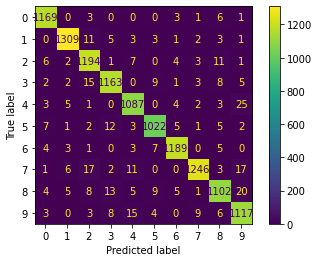

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pred = rf.predict(x_val)

# Validation data accuracy
predictions = rf.predict(x_val)
targets = y_val
print("Validation data error: " + str(1- accuracy_score(targets, predictions)) + '\n')

print("Classification Report")
print(classification_report(y_val, pred))

print("Confusion Matrix")
cm = confusion_matrix(y_val, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

Next, let's get some more information about this model (such as it's n_estimators) and see how it performs against the test data. 

In [ ]:
# What parameters was this random forest created with?
print("parameters = " + str(rf.get_params(deep=True)))

# How does it do against the test dataset?
predictions = rf.predict(x_test)
targets = y_test
print("Test data error: " + str(1 - accuracy_score(targets, predictions)))
print("Test data accuracy: " + str(accuracy_score(targets, predictions)))

parameters = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test data error: 0.03159999999999996
Test data accuracy: 0.9684


## Tuning the hyperparameters

As we can see above, the default RandomForestsClassifier hyperparameters are already quite good for classifying MNIST digits by pixel features. But we want to see if we can do better.

In the next cell, we loop creating and fitting models over a list of `n_estimators` in order to get a decent range of results.

In [ ]:
import time
from sklearn.metrics import accuracy_score

# This contains all the default parameters.
parameters = {
              "max_depth": None, 
              "min_samples_split": 2, 
              "min_samples_leaf": 1, 
              "min_impurity_decrease": 0,
              "max_features": "auto", 
              "criterion": "gini" # "entropy"
             }

n_estimators = [1, 5, 10, 50, 100, 500, 1000, 1500, 2500]

print("Parameters = %s\n" % str(parameters))

cross_val_metrics = np.zeros((len(n_estimators), 2), dtype=float)

for i, j in enumerate(n_estimators):
  start_time = time.time()

  rf = RandomForestClassifier(
                              n_estimators = n_estimators[i],
                              max_depth = parameters["max_depth"], 
                              min_samples_split = parameters["min_samples_split"], 
                              min_samples_leaf = parameters["min_samples_leaf"], 
                              min_impurity_decrease=parameters['min_impurity_decrease'], 
                              max_features = parameters["max_features"], 
                              criterion = parameters["criterion"], 
                              n_jobs=-1, # This ensures the model is being trained as fast as possible.
                              # tree_method = 'gpu_hist',
                              random_state=1778)

  rf.fit(x_train, y_train)

  # How did our model perform?
  print(str(j) + " estimators:")

  # Training data accuracy
  predictions = rf.predict(x_train)
  targets = y_train
  cross_val_metrics[i, 0] = accuracy_score(targets, predictions)
  
  # Validation data accuracy
  # predictions = rf.predict(x_val)
  # targets = y_val
  # cross_val_metrics[i, 1] = accuracy_score(targets, predictions)

  # Testing data accuracy
  predictions = rf.predict(x_test)
  targets = y_test
  cross_val_metrics[i, 1] = accuracy_score(targets, predictions)

  lap = time.time() - start_time
  print("\tTime elapsed: %d m %.2f s" % (int(lap / 60) , lap - (int(lap / 60) * 60)))
  print("\tTraining data error: " + str(1 - cross_val_metrics[i, 0]))
  # print("\tValidation data accuracy: %f\n" % cross_val_metrics[i, 1])
  print("\tTesting data error: " + str(1 - cross_val_metrics[i, 1]))
  print("\tTesting data accuracy: " + str(cross_val_metrics[i, 1]) + '\n')



Parameters = {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'max_features': 'auto', 'criterion': 'gini'}

1 estimators:
	Time elapsed: 0 m 0.59 s
	Training data error: 0.07152083333333337
	Testing data error: 0.19389999999999996
	Testing data accuracy: 0.8061

5 estimators:
	Time elapsed: 0 m 0.57 s
	Training data error: 0.006687499999999957
	Testing data error: 0.0786
	Testing data accuracy: 0.9214

10 estimators:
	Time elapsed: 0 m 0.68 s
	Training data error: 0.0009583333333332833
	Testing data error: 0.054400000000000004
	Testing data accuracy: 0.9456

50 estimators:
	Time elapsed: 0 m 2.21 s
	Training data error: 0.0
	Testing data error: 0.03500000000000003
	Testing data accuracy: 0.965

100 estimators:
	Time elapsed: 0 m 4.15 s
	Training data error: 0.0
	Testing data error: 0.032399999999999984
	Testing data accuracy: 0.9676

500 estimators:
	Time elapsed: 0 m 20.24 s
	Training data error: 0.0
	Testing data error: 0.0295999999999999

Based off of those models, what trend do we see for the validation error as the number of estimators (trees) gets larger?

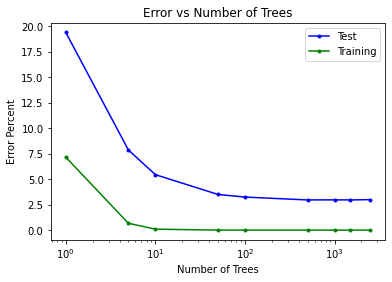

In [ ]:
# print(cross_val_metrics)

fig = plt.figure()
ax = plt.gca()
ax.plot(n_estimators, 100 * (1 - cross_val_metrics[:,1]), "b.-", label='Test')
ax.plot(n_estimators, 100 * (1 - cross_val_metrics[:,0]), "g.-", label='Training')
ax.set_xlabel('Number of Trees')
ax.set_title('Error vs Number of Trees')
ax.set_ylabel('Error Percent')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc='best')


So, as we can see the validation error approaches zero as we add more trees.

#XGBoost

In [ ]:
from sklearn.metrics import accuracy_score
import time
import torch as torch

# print(torch.cuda.get_device_name(0))

parameters = {
              "tree_method": "exact",
              'gpu_id': 0,
              'n_jobs': -1,
              'booster': 'gbtree', # can also "gblinear" or "dart"
              'max_depth': 24, 
              'eval_metric': 'mlogloss', # accuracy_score, #'mlogloss', # 'mlogloss' by default 
              'gamma': 0,
              'learning_rate': 2,
              'subsample': 0.9,
              'colsample_bynode':0.2
            }

import xgboost as xgb

n_estimators = [1, 5, 10, 50, 100, 500, 1000, 1500, 2500]

cross_val_metrics = np.zeros((len(n_estimators), 2), dtype=float)

print("Parameters = %s\n" % str(parameters))

for i, j in enumerate(n_estimators):
  start_time = time.time()

  rf = xgb.XGBRFClassifier(
                            n_estimators = n_estimators[i],
                            tree_method = parameters['tree_method'],
                            gpu_id = parameters['gpu_id'],
                            n_jobs = parameters['n_jobs'],
                            # booster = parameters['booster'],
                            max_depth = parameters['max_depth'],
                            eval_metric = parameters['eval_metric'],
                            gamma = parameters['gamma'],
                            learning_rate = parameters['learning_rate'],
                            subsample = parameters['subsample'],
                            colsample_bynode = parameters['colsample_bynode'],
                            verbosity = 0,
                            use_label_encoder = False,
                            random_state = 1778
                           )
  
  rf.fit(x_train, y_train)
  
  # How did our model perform?
  print(str(j) + " estimators:")

  # Training data accuracy
  predictions = rf.predict(x_train)
  targets = y_train
  cross_val_metrics[i, 0] = accuracy_score(targets, predictions)
  
  # Validation data accuracy
  # predictions = rf.predict(x_val)
  # targets = y_val
  # cross_val_metrics[i, 1] = accuracy_score(targets, predictions)

  # Test data accuracy
  predictions = rf.predict(x_test)
  targets = y_test
  cross_val_metrics[i, 1] = accuracy_score(targets, predictions)


  lap = time.time() - start_time
  print("\tTime elapsed: %d m %.2f s" % (int(lap / 60) , lap - (int(lap / 60) * 60)))
  print("\tTrain data accuracy: %f" % cross_val_metrics[i, 0])
  print("\tTest data accuracy: %f\n" % cross_val_metrics[i, 1])

Parameters = {'tree_method': 'exact', 'gpu_id': 0, 'n_jobs': -1, 'booster': 'gbtree', 'max_depth': 24, 'eval_metric': 'mlogloss', 'gamma': 0, 'learning_rate': 2, 'subsample': 0.9, 'colsample_bynode': 0.2}

1 estimators:
	Time elapsed: 0 m 2.78 s
	Train data accuracy: 0.969833
	Test data accuracy: 0.896200

5 estimators:
	Time elapsed: 0 m 5.04 s
	Train data accuracy: 0.993563
	Test data accuracy: 0.952300

10 estimators:
	Time elapsed: 0 m 9.47 s
	Train data accuracy: 0.995500
	Test data accuracy: 0.960200

50 estimators:
	Time elapsed: 0 m 44.91 s
	Train data accuracy: 0.996542
	Test data accuracy: 0.963800

100 estimators:
	Time elapsed: 1 m 30.85 s
	Train data accuracy: 0.996521
	Test data accuracy: 0.964800

500 estimators:
	Time elapsed: 7 m 31.45 s
	Train data accuracy: 0.996792
	Test data accuracy: 0.964900

1000 estimators:
	Time elapsed: 14 m 53.43 s
	Train data accuracy: 0.996646
	Test data accuracy: 0.965400

1500 estimators:
	Time elapsed: 22 m 34.26 s
	Train data accuracy:

[[0.969833 0.8962  ]
 [0.993563 0.9523  ]
 [0.9955   0.9602  ]
 [0.996542 0.9638  ]
 [0.996521 0.9648  ]
 [0.996792 0.9649  ]
 [0.996646 0.9654  ]
 [0.996687 0.9656  ]]


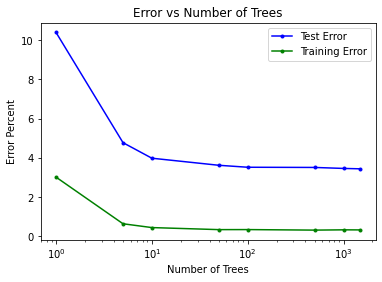

In [ ]:
import matplotlib.pyplot as plt

n_estimators = [1, 5, 10, 50, 100, 500, 1000, 1500]
cross_val_metrics = np.zeros((len(n_estimators), 2), dtype=float)
cross_val_metrics[:, 0] = [0.969833,0.993563,0.995500,0.996542,0.996521,0.996792,0.996646,0.996687]
cross_val_metrics[:, 1] = [0.896200, 0.952300, 0.960200, 0.963800, 0.964800, 0.964900, 0.965400, 0.965600]
print(cross_val_metrics)

fig = plt.figure()
ax = plt.gca()
ax.plot(n_estimators, (1 - cross_val_metrics[:,1]) * 100, "b.-", label='Test Error')
ax.plot(n_estimators, (1 - cross_val_metrics[:,0]) * 100, "g.-", label='Training Error')
ax.set_xlabel('Number of Trees')
ax.set_title('Error vs Number of Trees')
ax.set_ylabel('Error Percent')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc='upper right')